In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['508_right.jpeg', '208_right.jpeg', '1073_right.jpeg', '1050_right.jpeg', '1206_left.jpeg', '754_right.jpeg', '869_right.jpeg', '997_left.jpeg', '554_right.jpeg', '1037_right.jpeg', '49_right.jpeg', '169_right.jpeg', '456_right.jpeg', '149_right.jpeg', '283_right.jpeg', '197_left.jpeg', '773_right.jpeg', '252_right.jpeg', '579_right.jpeg', '739_left.jpeg', '104_left.jpeg', '929_left.jpeg', '702_right.jpeg', '482_left.jpeg', '623_left.jpeg', '210_left.jpeg', '734_left.jpeg', '216_right.jpeg', '607_left.jpeg', '164_left.jpeg', '64_left.jpeg', '1165_right.jpeg', '805_right.jpeg', '95_left.jpeg', '465_left.jpeg', '1020_right.jpeg', '10_right.jpeg', '644_left.jpeg', '20_right.jpeg', '317_left.jpeg', '398_right.jpeg', '156_left.jpeg', '73_right.jpeg', '294_right.jpeg', '1049_right.jpeg', '311_right.jpeg', '613_right.jpeg', '449_left.jpeg', '986_left.jpeg', '558_left.jpeg', '1199_left.jpeg', '604_right.jpeg', '839_left.jpeg', '52_left.jpeg', '177_left.jpeg', '307_left.jpeg', '65_left.jpeg', 

In [2]:
# Reading the data files
import pandas as pd

trainLabels = pd.read_csv("../input/trainLabels.csv")
trainLabels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [3]:
from PIL import Image                   # Library for image functions
from keras.preprocessing import image   # Using Keras for CNN
import os
import numpy as np

img_rows, img_cols = 256, 256           # resize the image to (256, 256)


listing = os.listdir("../input") 
listing.remove("trainLabels.csv")

immatrix = []                         # Image matrix for storing pixel values
imlabel = []                          # Labels for that image

for file in listing:
    base = os.path.basename("../input/" + file)
    fileName = os.path.splitext(base)[0]
    imlabel.append(trainLabels.loc[trainLabels.image==fileName, 'level'].values[0])
    im = Image.open("../input/" + file)
    img = np.array(im.resize((img_rows,img_cols)))
    
    # convert to green channel only
    img[:,:,[0,2]] = 0
    immatrix.append(img)

Using TensorFlow backend.


level: 0


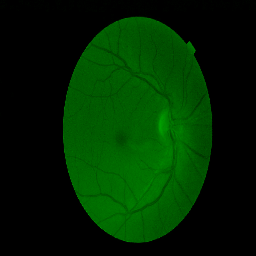

In [5]:
# Display one of the images with its label
'''Following are labels in the data :
0 - No DR
1 - Mild
2 - Moderate
3 - Severe
4 - Proliferative DR'''
im = Image.fromarray(immatrix[1],'RGB')
print("level:",imlabel[1])
im

In [6]:
# Applying transformations to images to avoid overfitting
import random

# define transformation methods
def horizontal_flip(image_array):
    return image_array[:, ::-1]

def vertical_flip(image_array):
    return image_array[::-1,:]

def random_transform(image_array):
    if random.random() < 0.5:
        return vertical_flip(image_array)
    else:
        return horizontal_flip(image_array)

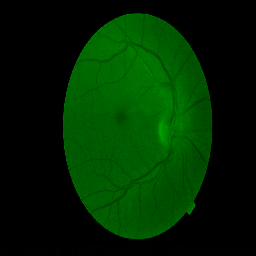

In [7]:
# Displaying a transformed image : vertivcally flipped
im = Image.fromarray(vertical_flip(immatrix[1]),'RGB')
im

In [8]:
# Appending the transformed images into the original image matrix along with labels
length = len(immatrix)
for i in range(length):
    if random.random() < 0.1:
        immatrix.append(random_transform(immatrix[i]))
        imlabel.append(imlabel[i])
        
print("Size of image array before augmentation: ", length)
print("Size fo image array after augmentation: ", len(immatrix))

Size of image array before augmentation:  1000
Size fo image array after augmentation:  1106


In [9]:
# Shuffling the data to avoid consecutive images together 
from sklearn.utils import shuffle

data,label = shuffle(immatrix, imlabel, random_state=42)
train_data = [data,label]

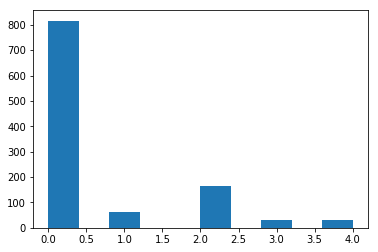

In [10]:
# Visualising the dataset: counting the number of images for each label(0 has highest)
import matplotlib.pyplot as plt

plt.hist(label)
plt.show()

In [11]:
# Splitting the dataset into training and testing set
# Test size is 10% of the data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_data[0], train_data[1], test_size = 0.1, random_state = 42)

print(np.array(x_train).shape)
print(np.array(y_train).shape)

(995, 256, 256, 3)
(995,)


In [12]:
#Normalising the dataset: converting all big values into decimals for easy computation
from keras.utils import np_utils

y_train = np_utils.to_categorical(np.array(y_train), 5)
y_test = np_utils.to_categorical(np.array(y_test), 5)

x_train = np.array(x_train).astype("float32")/255.
x_test = np.array(x_test).astype("float32")/255.

print(np.array(y_train).shape)

(995, 5)


In [13]:
# Building the actual CNN using Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train[0].shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(activation='softmax', units=5))

model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [14]:
# Summary of the model built
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 254, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 127, 127, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
__________

In [15]:
# Training the CNN in 10 epochs batch_size is 64
model.fit(x_train, y_train, batch_size = 64, epochs=10, shuffle=True, verbose=2)

Epoch 1/10
 - 284s - loss: 1.5737 - acc: 0.5126
Epoch 2/10
 - 274s - loss: 1.4844 - acc: 0.7357
Epoch 3/10
 - 273s - loss: 1.3302 - acc: 0.7387
Epoch 4/10
 - 273s - loss: 1.0892 - acc: 0.7387
Epoch 5/10
 - 273s - loss: 0.9477 - acc: 0.7387
Epoch 6/10
 - 272s - loss: 0.9225 - acc: 0.7387
Epoch 7/10
 - 272s - loss: 0.9174 - acc: 0.7387
Epoch 8/10
 - 272s - loss: 0.9151 - acc: 0.7387
Epoch 9/10
 - 272s - loss: 0.8966 - acc: 0.7387
Epoch 10/10
 - 272s - loss: 0.8890 - acc: 0.7387


In [16]:
predictions = model.predict(x_test)
predictions

array([[0.5392133 , 0.10270069, 0.1897704 , 0.08193194, 0.08638375],
       [0.6265726 , 0.08037937, 0.16994686, 0.05850107, 0.06460015],
       [0.5879039 , 0.08920152, 0.17928798, 0.06907199, 0.07453461],
       [0.5610696 , 0.09631315, 0.18448175, 0.07641702, 0.08171842],
       [0.5535354 , 0.0986234 , 0.18632275, 0.07777101, 0.08374742],
       [0.5421049 , 0.1020257 , 0.18948695, 0.07950313, 0.08687928],
       [0.58674407, 0.089081  , 0.17914693, 0.06968276, 0.07534517],
       [0.5467775 , 0.10061856, 0.18973404, 0.07813254, 0.0847373 ],
       [0.5982725 , 0.08558888, 0.17589064, 0.06748572, 0.07276231],
       [0.49749148, 0.11451396, 0.19328918, 0.09480546, 0.09989992],
       [0.48580822, 0.11686352, 0.19856027, 0.09589155, 0.10287648],
       [0.55217755, 0.09841841, 0.18853007, 0.07713796, 0.08373591],
       [0.62209004, 0.07982688, 0.1709598 , 0.06073936, 0.06638391],
       [0.45242295, 0.12613723, 0.20290619, 0.10654091, 0.11199269],
       [0.5461809 , 0.10180354, 0.

In [17]:
# Find the accuracy of the model
# Returns the loss and accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print(score)

[0.979975641310752, 0.7297297313406661]


In [18]:
print(model.metrics_names)

['loss', 'acc']
